## __MNIST modelling with Convolution Neural Network (CNN) using JAX / Haiku__

In [1]:
!pip install -q jax jaxlib optax dm-haiku

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.8/373.8 kB 24.5 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp
import optax
import haiku as hk
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Tuple
import matplotlib.pyplot as plt

In [3]:
train_set = tfds.load("mnist", split="train", shuffle_files=True, as_supervised=True)
test_set = tfds.load("mnist", split="test", shuffle_files=True, as_supervised=True)

train_size = train_set.cardinality().numpy()
test_size = test_set.cardinality().numpy()

print("Training set size:", train_size)
print("Test set size:", test_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.AGXM2K_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.AGXM2K_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Training set size: 60000
Test set size: 10000


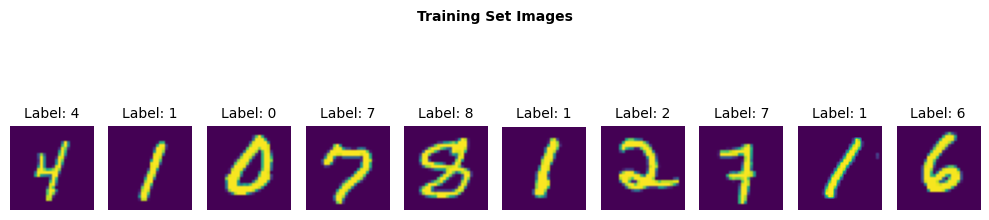

In [4]:
def visualize_images(dataset, title, num_samples=10):

    plt.figure(figsize=(10, 3))
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        image = image.numpy()
        label = label.numpy()

        ax = plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f'Label: {label}', fontsize=10)
        plt.axis('off')

    plt.suptitle(title, fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize training samples
visualize_images(train_set, "Training Set Images", num_samples=10)

In [5]:
#setting up parameters
seed = 10
rng = jax.random.PRNGKey(seed)
AUTOTUNE = tf.data.AUTOTUNE

batch_size = 128
learning_rate = 1e-3
num_epochs = 10

In [6]:
def normalize_images(image, label):
  return tf.cast(image, tf.float32) / 255., label

In [7]:
def load_data():

  train_ds = tfds.load("mnist", split="train", shuffle_files=True, as_supervised=True)
  test_ds = tfds.load("mnist", split="test", shuffle_files=True, as_supervised=True)

  train_set = train_ds.map(normalize_images).batch(batch_size).prefetch(AUTOTUNE)
  test_set = test_ds.map(normalize_images).batch(batch_size).prefetch(AUTOTUNE)

  return train_set, test_set

### **creating MODEL**

In [8]:
def cnn_model(batch: jnp.ndarray) -> jnp.ndarray:

  net = hk.Sequential([
      hk.Conv2D(32, kernel_shape=(3,3), padding="SAME"),
      jax.nn.relu,
      hk.MaxPool(window_shape=(2,2), strides=(2,2), padding="SAME"),
      hk.Conv2D(64, kernel_shape=(3,3), padding="SAME"),
      jax.nn.relu,
      hk.MaxPool(window_shape=(2,2), strides=(2,2), padding="SAME"),
      hk.Flatten(),
      hk.Linear(128),
      jax.nn.relu,
      hk.Linear(10),
  ])

  return net(batch)

In [9]:
#Transforming the function into a HAIKU module

cnn_model = hk.transform(cnn_model)

 In Haiku, ``transform()`` is to transform that function into a pair of functions that allow us to lift all the parameters out of the function (``f.init``) and apply the function with a given set of parameters (``f.apply``):

### **Initializing model parameters and optimizer state**


In [10]:
def initialize_training(rng_key: jnp.ndarray, batch: jnp.ndarray) -> Tuple[hk.Params, optax.OptState]:
  """
  Input: random number generator key for reprodicibility, and a sample batch of data
  Output: a tuple containing the initialized parameters and optimizer state
  """
  params = cnn_model.init(rng_key, batch) #to get the initial state
  optimizer = optax.adam(learning_rate) #selecting adam optimizer with learning_rate
  optimizer_state = optimizer.init(params) #initializing optimizer state with parameters

  return params, optimizer_state

### **calculating loss and accuracy**

In [11]:
# Computing Loss

@jax.jit #decorator that do Just-In-Time compilation on GPU
def compute_loss(params: hk.Params, batch: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
  """
  Input: current model parameters, a batch of data, and the corresponding labels
  Output: the computed loss
  """
  logits = cnn_model.apply(params, None, batch)       #we can pass None as RNG Key
  one_hot_encoded_labels = jax.nn.one_hot(labels, 10) #one-hot encoding labels with 10 classes
  loss = optax.softmax_cross_entropy(logits= logits, labels=one_hot_encoded_labels).mean() #calculates loss over the batch
  return loss

# Computing Accuracy

@jax.jit
def compute_accuracy(params: hk.Params, batch: jnp.ndarray, labels:jnp.ndarray) -> jnp.ndarray:
  """
  Input: current model parameters, a batch of data, and the corresponding labels
  Output: the computed accuracy
  """
  logits = cnn_model.apply(params, None, batch)
  predictions = jnp.argmax(logits, axis=-1) #getting class with highest probability, in last axis
  return jnp.mean(predictions == labels)

- **``jax.value_and_grad``** : It is a function with the same arguments as ``function`` that evaluates both ``function`` and the __gradient__ of ``function`` and __returns them as a pair (a two-element tuple)__

- **``optax.apply_update``**: It applies an update to a set of parameters, and then returns the updated parameters to the caller.

In [12]:
@jax.jit

def training_step(params: hk.Params,
                  optimizer_state: optax.OptState,
                  batch: jnp.ndarray, labels: jnp.ndarray) -> Tuple[hk.Params, optax.OptState, jnp.ndarray]:

  #computing loss and gradients
  loss, grads = jax.value_and_grad(compute_loss)(params, batch, labels)

  #updating parameters
  optimizer = optax.adam(learning_rate)
  updates, new_optimizer_state = optimizer.update(grads, optimizer_state, params)
  new_params = optax.apply_updates(params, updates)

  return new_params, new_optimizer_state, loss


def evaluation_step(params: hk.Params, dataset) -> Tuple[float, float]:

  total_loss = 0.0
  total_accuracy = 0.0
  num_batches = 0

  for batch_data in tfds.as_numpy(dataset):
    images, labels = batch_data
    batch_loss = compute_loss(params, images, labels)
    batch_accuracy = compute_accuracy(params, images, labels)

    total_loss += batch_loss
    total_accuracy += batch_accuracy
    num_batches += 1

  average_loss = total_loss / num_batches
  average_accuracy = total_accuracy / num_batches

  return average_loss, average_accuracy

In [13]:
train_set, test_set = load_data()

#getting a sample batch for initialization
sample_batch = next(iter(tfds.as_numpy(train_set.take(1))))
sample_images, _ = sample_batch

#initialize model and optimizer
init_key = jax.random.PRNGKey(seed)
params, optimizer_state = initialize_training(init_key, sample_images)

#for training record
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

import time
start = time.perf_counter()

for epoch in range(num_epochs):
  epoch_loss = 0.0
  epoch_accuracy = 0.0
  num_batches = 0

  for batch_data in tfds.as_numpy(train_set):
    image, labels = batch_data
    params, optimizer_state, loss = training_step(params, optimizer_state, image, labels)
    #training_step included calculating loss, we do not need to explicitly compute_loss now
    accuracy = compute_accuracy(params, image, labels)
    epoch_loss += loss
    epoch_accuracy += accuracy
    num_batches += 1

  average_train_loss = epoch_loss / num_batches
  average_train_accuracy = epoch_accuracy / num_batches

  #evaluation
  test_loss, test_accuracy = evaluation_step(params, test_set)
  train_losses.append(average_train_loss)
  train_accuracies.append(average_train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  print(f"Epoch {epoch+1} : Train Loss: {average_train_loss:.4f},"
        f"Train Accuracy: {average_train_accuracy:.4f}",
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
end = time.perf_counter()
s2mps = lambda s: f"{s // 60:.0f} min {s % 60:.2f} s"
print(f"Total Training Time: {s2mps(end - start)}")

Epoch 1 : Train Loss: 0.1740,Train Accuracy: 0.9548 Test Loss: 0.0811, Test Accuracy: 0.9723
Epoch 2 : Train Loss: 0.0533,Train Accuracy: 0.9872 Test Loss: 0.0552, Test Accuracy: 0.9812
Epoch 3 : Train Loss: 0.0366,Train Accuracy: 0.9922 Test Loss: 0.0471, Test Accuracy: 0.9848
Epoch 4 : Train Loss: 0.0266,Train Accuracy: 0.9949 Test Loss: 0.0485, Test Accuracy: 0.9847
Epoch 5 : Train Loss: 0.0198,Train Accuracy: 0.9969 Test Loss: 0.0438, Test Accuracy: 0.9877
Epoch 6 : Train Loss: 0.0147,Train Accuracy: 0.9982 Test Loss: 0.0509, Test Accuracy: 0.9854
Epoch 7 : Train Loss: 0.0130,Train Accuracy: 0.9986 Test Loss: 0.0433, Test Accuracy: 0.9885
Epoch 8 : Train Loss: 0.0114,Train Accuracy: 0.9987 Test Loss: 0.0444, Test Accuracy: 0.9882
Epoch 9 : Train Loss: 0.0088,Train Accuracy: 0.9992 Test Loss: 0.0357, Test Accuracy: 0.9894
Epoch 10 : Train Loss: 0.0072,Train Accuracy: 0.9996 Test Loss: 0.0472, Test Accuracy: 0.9886
Total Training Time: 0 min 38.46 s


On T4,<br>
Running for $1$ epoch takes $11.97$s<br>
Running for 2 epoch takes $21.15s$<br>
Running for 3 epoch takes $23.53s$<br>
Running for 4 epoch takes $30.86s$<br>
Running for 5 epoch takes $31.07s$<br>
Running for 10 epoch takes $38.46s$

JAX uses Accelerated Linear Algebra (XLA) for compilation for those are marked by decorator ``@jax.jit``. This is Just-in-time compilation happen on the first execution, so first epoch was slow, and next onwards sped up.

### Plotting

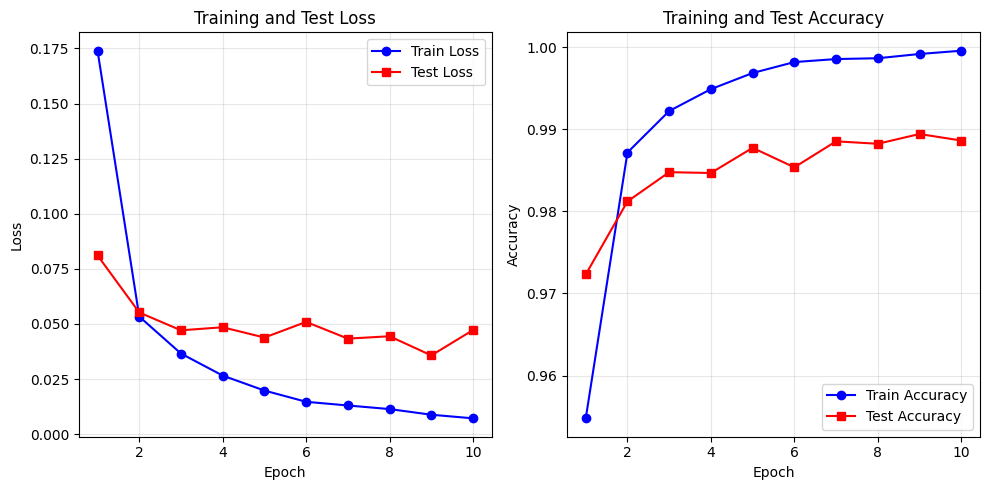

In [14]:
def plot_results(train_losses, train_accuracies, test_losses, test_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    epochs = range(1, num_epochs + 1)

    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', marker='o')
    ax1.plot(epochs, test_losses, 'r-', label='Test Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, train_accuracies, 'b-', label='Train Accuracy', marker='o')
    ax2.plot(epochs, test_accuracies, 'r-', label='Test Accuracy', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Test Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_results(train_losses, train_accuracies, test_losses, test_accuracies)